# Testing the luseepy integration

The "Sun" object can be used to either calculate the Sun trajectory based on the time interval, or
read previously produced data from a file. Added a couple of validation plots.

In [1]:
# Imports and utility

# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# General dependencies
import  sys
import  numpy as np
import  matplotlib.pyplot as plt

# LuSEE
import  lusee
from    lusee import Observation
from    nav import *

# ----------------------------------------------------
print("Path:")
print("-------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')
print("-------------------------------------")
print(f'''lusee version: {lusee.__version__}''')



Path:
-------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
-------------------------------------
lusee version: 1.2-dev


In [6]:
# Basic test of the Observation object
interval = "2025-02-10 00:00:00 to 2025-02-11 23:45:00"

#tuple_test = ("2025-02-10 00:00:00", "2025-02-11 23:45:00")
#o_test = Observation(tuple_test, deltaT_sec = 15*60)

#print(f'''time: {o_test.time}''')
#print(f'''deltaT_sec: {o_test.deltaT_sec}''')
#print(f'''lun_height_m: {o_test.lun_height_m}''')
#print(f'''lun_lun_long_deg: {o_test.lun_long_deg}''')
#print(f'''lun_lun_lat_deg: {o_test.lun_lat_deg}''')



---

### Calculate or read the Sun and Satellite trajectories in the sky

In the two cells below, either calculate from scratch, or read data calculated previously.


In [14]:
# Calculate the trajectory at runtime

interval = "2025-02-10 00:00:00 to 2025-03-07 23:45:00"
mySun = Sun()
mySun.calculate(interval)

o       = Observation(interval)
S       = Satellite()
obsat   = ObservedSatellite(o,S)


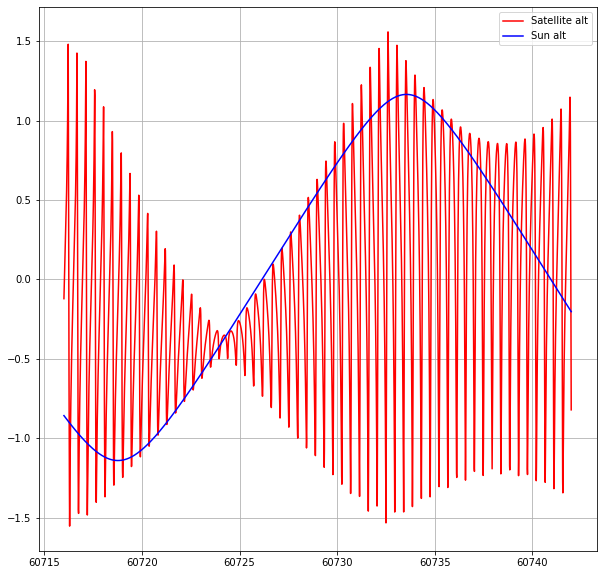

In [18]:
plt.rcParams["figure.figsize"] = [10., 10.]

ax=plt.subplot()
mjd = [timepoint.mjd for timepoint in o.times]
ax.plot(mjd, obsat.alt_rad(),  color="red",    label="Satellite alt")
ax.plot(mySun.mjd, mySun.alt,  color="blue", label="Sun alt")
ax.grid(True)
_ = plt.legend()


In [2]:
# Read the prefab data on sun trajectory
import os
from nav import Sun

# ---
print('Current directory:', os.getcwd())

mySun = Sun()

# cachefile = '../data/2025-02-04_03-07.npy'
cachefile = '../data/2025-02-04_2025-08-10.npy'

mySun.read_trajectory(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')

print(mySun.crossings)

# prev = None

# for crs in mySun.crossings:
#     # print(mySun.alt[crs:crs+2])
#     print(mySun.mjd[crs])
#     prev = mySun.mjd[crs]
#     if prev is not None:
#         print(mySun.mjd[crs] - prev)
#         prev = mySun.mjd[crs]
        


# for d in mySun.day: print(d)



Current directory: /home/maxim/projects/lusee/opsim/notebooks
Number of points read from the file ../data/2025-02-04_2025-08-10.npy: 18048
[  133  1549  2970  4391  5804  7228  8634 10061 11463 12890 14291 15717
 17120]


---

### Plot

Regardless of whether it was calculated or read from a file, we can check the data with some graphics

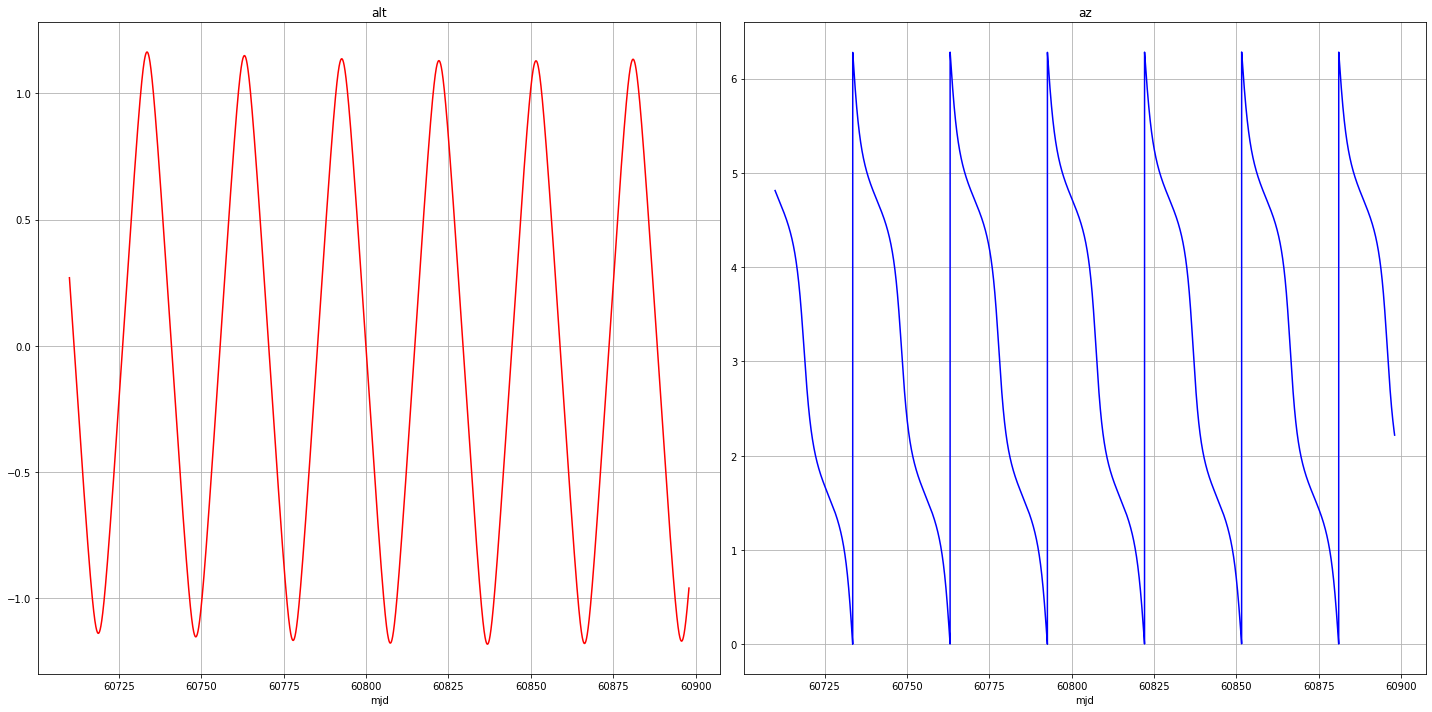

In [4]:
fig, (p1, p2) = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = [20., 10.]
plt.rcParams["figure.autolayout"] = True

p1.set_title("alt")
p1.plot(mySun.mjd, mySun.alt, color="red")
p1.grid(True)
p1.set_xlabel('mjd')


p2.set_title("az")
p2.plot(mySun.mjd, mySun.az, color="blue")
p2.grid(True)
p2.set_xlabel('mjd')
# plt.title("Time interval: "+interval)
plt.show()


---

Note that the time unit for "hours" is still the same as for other values, in the original case it's 15 min intervals, which is 0.25 hrs

In [5]:
alt = mySun.alt
mjd = mySun.mjd
az  = mySun.az
hrs = mySun.hrsFromSunrise
print(hrs[0:100]) # test printout

[-4280.25 -4280.   -4279.75 -4279.5  -4279.25 -4279.   -4278.75 -4278.5
 -4278.25 -4278.   -4277.75 -4277.5  -4277.25 -4277.   -4276.75 -4276.5
 -4276.25 -4276.   -4275.75 -4275.5  -4275.25 -4275.   -4274.75 -4274.5
 -4274.25 -4274.   -4273.75 -4273.5  -4273.25 -4273.   -4272.75 -4272.5
 -4272.25 -4272.   -4271.75 -4271.5  -4271.25 -4271.   -4270.75 -4270.5
 -4270.25 -4270.   -4269.75 -4269.5  -4269.25 -4269.   -4268.75 -4268.5
 -4268.25 -4268.   -4267.75 -4267.5  -4267.25 -4267.   -4266.75 -4266.5
 -4266.25 -4266.   -4265.75 -4265.5  -4265.25 -4265.   -4264.75 -4264.5
 -4264.25 -4264.   -4263.75 -4263.5  -4263.25 -4263.   -4262.75 -4262.5
 -4262.25 -4262.   -4261.75 -4261.5  -4261.25 -4261.   -4260.75 -4260.5
 -4260.25 -4260.   -4259.75 -4259.5  -4259.25 -4259.   -4258.75 -4258.5
 -4258.25 -4258.   -4257.75 -4257.5  -4257.25 -4257.   -4256.75 -4256.5
 -4256.25 -4256.   -4255.75 -4255.5 ]


In [8]:

iMidnight       = np.argmin(alt)
iNoon           = np.argmax(alt)
iSundown1       = np.argmin(np.abs(alt[:iMidnight]))
iSunrise        = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
iSundown2       = np.argmin(abs(alt[iNoon:])) + iNoon
hoursFromSunset = (mjd - mjd[iSundown1])*24

t_inc = 0.25 # Varies! But approx 0.25hrs ticks

alt_sun_top     = np.asarray(alt)+0.265
iSuntoprise     = np.argmin(np.abs(alt_sun_top[iMidnight:iNoon])) + iMidnight
iSuntopdown2    = np.argmin(abs(alt_sun_top[iNoon:])) + iNoon

# plot altitude through the cycle
plt.plot(hrs, alt, label='Alt')
plt.axhline(0, c='k', lw=2)
plt.grid(True)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Sun Altitude [deg]")

# plot track of sun in 3D during 1 lunar day
plt.figure()
ax = plt.axes(projection='3d')
# day_mask = alt > 0
day_mask = [False]*len(alt) | (alt>0)
for i in range(len(day_mask)):
    if (i<iMidnight):
        day_mask[i] = False

# sun = altaz2xyz(alt, az)
sunDay = altaz2xyz(alt, az)[day_mask]

ax.plot3D(sunDay[:,0],sunDay[:,1],sunDay[:,2])
ax.scatter3D(sunDay[0,0],sunDay[0,1],sunDay[0,2], c='r', label='rise')
ax.scatter3D(sunDay[-1,0],sunDay[-1,1],sunDay[-1,2], c='k', label='set')

ax.set_xlabel('azimuth W->E')
ax.set_ylabel('azimuth S->N')
ax.set_zlabel('altitude')
ax.legend()


ValueError: attempt to get argmin of an empty sequence

In [ ]:
from scipy.interpolate import interp1d

plt.plot(hrs,   alt, color="red",    label="Alt")
plt.xlim(-10, 360)
plt.grid(True)
plt.title("Alt vs Hours to sunrise")


#Lunar surface temperature data
# day_hrs = PVProjArea()[0]
hrs_per_lunar_day = 2551443/3600
temp_data = np.loadtxt("../reference/lunarTemperature30degDiviner.txt", delimiter=',') #Data starts at midnight!
time_hrs=(temp_data[:,0]-6)/24*hrs_per_lunar_day; temp=temp_data[:,1] #-6hrs to shift to hours from sunrise
temp_fit = interp1d(time_hrs,temp,kind='cubic')

print(f'''Data array: {temp_data.size}, hours per lunar day: {hrs_per_lunar_day}, t_inc: {t_inc}''')

# Interpolate temp data over daylight hours with same spacing as day_hrs
# Edge pad to length of day_hrs so array size/time increments match
# Power outside daylight hours will be zero'd by PVProjArea func, so thermal eff value meaningless outside daylight
time_day = np.arange(0,hrs_per_lunar_day/2,t_inc) 
#temp_matched = np.pad(temp_fit(time_day),(iSunrise+1,len(day_hrs)-iSundown2+2), mode='edge') 
# Copy end of day temps to previous day
#temp_matched[:iSundown1] = temp_matched[(iSundown2-iSundown1):iSundown2]

# plt.plot(hrs,temp,'o', label='Temp Data')
# plt.plot(time_day, temp_fit(time_day), '-', label='Fit for Daytime')
# plt.plot(day_hrs, temp_matched, '--', label='Padded Fit')
# plt.legend()
# plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Temperature [K]")
# plt.title("Lunar Surface Temperature")

